In [1]:
import matplotlib as mpl
from Datasets import * 

import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=3, linewidth=120)
from LiteModels import DeepLite
from Datasets import *

from MMD.mmd import MMD_3_Sample_Test
import h5py as h5
from tqdm import trange
from scipy.misc import imresize
import seaborn as sns
import pandas as pd

from nuts import nuts
from nuts.emcee_nuts import NUTSSampler
from maf import experiments as ex

%matplotlib inline

Using cuDNN version 6021 on context None
Mapped name None to device cuda: GeForce GTX 1080 Ti (0000:84:00.0)


## Load data

In [2]:
seed = 1
noise_std = 0.05
#dname = "funnel"
#p = load_data("funnel",D=2,  N=5000, valid_thresh=0.0, noise_std = noise_std, seed=seed, itanh=False, whiten=True)
#p = load_data("spiral",D=2,  N=5000, data_args={"sigma":0.2}, valid_thresh=0.0, noise_std = noise_std, seed=seed, itanh=False, whiten=True)
p = load_data("ring",D=2, data_args={"nring":1, "sigma":0.2}, N=5000, valid_thresh=0.0, noise_std = noise_std, seed=seed, itanh=False, whiten=True)
D = p.D
    
plot_size=8
ngrid = 100

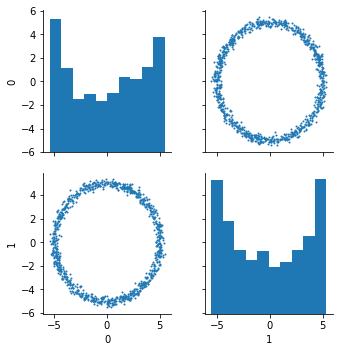

In [28]:
# visualise data

df = pd.DataFrame(p.sample(1000))
sns.pairplot(df,plot_kws=dict(s=4, alpha=1.0, linewidth=0))

# Training the model
If want to retrain, set `gpu_count=1` if you have a gpu

In [29]:
dl_model = DeepLite(p, npoint=100, nlayer=3, nneuron=20, init_log_lam=-3, points_std=0.0, keep_prob=1.0, init_weight_std=1.0, noise_std=0.0,
                    points_type="fixed", log_lam_weights=-6, step_size=1e-3, mixture_kernel=False, init_log_sigma=np.linspace(0,1,1), base=True,
                    niter=1000, ntrain=100, nvalid=100, patience=30, seed=seed,gpu_count=1)
res = dl_model.fit(niter=5000, ntrain=100, nvalid=100,ntest=500, nbatch=1, patience=30)
#dl_model.load()

trainining kernel:  21%|▏| 1026/5001 [01:58<06:47,  9.75it/s[{'test': '-12.927', 'loss': '-11.127'}]]


INFO:tensorflow:Restoring parameters from ckpts/R_D02_l3_nd20_np100_nt100_nv100_ptf_ss10_ni1000_n00_k10_m0_b1_p30_nk1_s01.ckpt
best score: -12.92713


# visualize some variables in the model

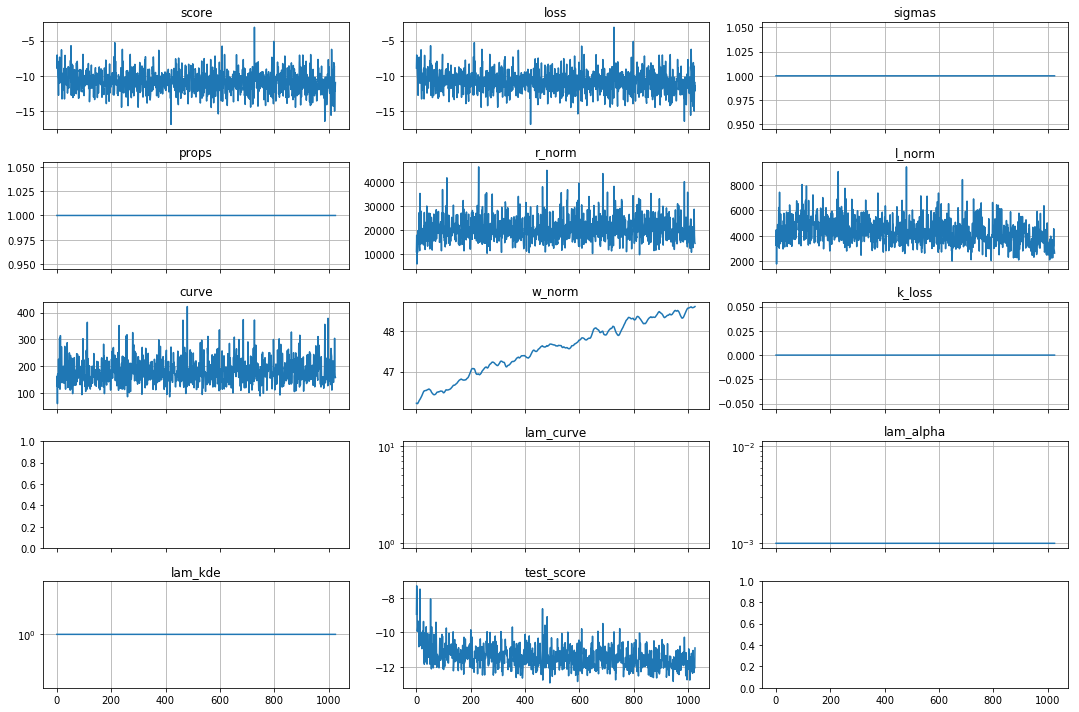

In [30]:
fig, axes = plt.subplots(5,3,figsize=(15,10), sharex=True)

axes = axes.flatten()
res = dl_model.state_hist

for ki, k in  enumerate(res):
    if k == "lam_norm":
        continue
    ax = axes[ki]
    ax.plot(res[k])
    ax.set_title(k)
    if "lam" in k: 
        ax.set_yscale("log")
    ax.grid("on")
        
        
fig.tight_layout()

In [31]:
# final fit of alphas. Better do it on cpu so have to redefine the model (set True) and tell it gpu_count = 0
dl_model.set_test(True, 0) 
dl_model.fit_alpha(5000)

INFO:tensorflow:Restoring parameters from ckpts/R_D02_l3_nd20_np100_nt100_nv100_ptf_ss10_ni1000_n00_k10_m0_b1_p30_nk1_s01.ckpt


In [32]:
# evaluate log likelihood, repeat to see whether reliable
for i in range(2):
    dl_model.logZ = None
    dl_model.estimate_normaliser(n=2*10**6, batch_size=10**5, std=p.test_data.std()*1.0)
    test_loglik = dl_model.estimate_data_lik(p.test_data, batch_size=p.test_data.shape[0])
    print test_loglik.mean()

-3.32416899283
-3.32409312857


In [33]:
p.logpdf_multiple(p.test_data).mean()

-3.2474670464591959

# Visualise density of two dimensions conditioned on others dimensions being zeros

In [4]:
def get_grid(r, i, j, cond):


    grid = np.meshgrid(r,r)

    grid = np.stack(grid,2)
    grid = grid.reshape(-1,2)
    
    num_point = len(grid)
    grid_cond = np.tile(cond[None,:], [num_point, 1])
    
    grid_cond[:,i] = grid[:,0]
    grid_cond[:,j] = grid[:,1]
    return grid_cond

(-8.0, 8.0)

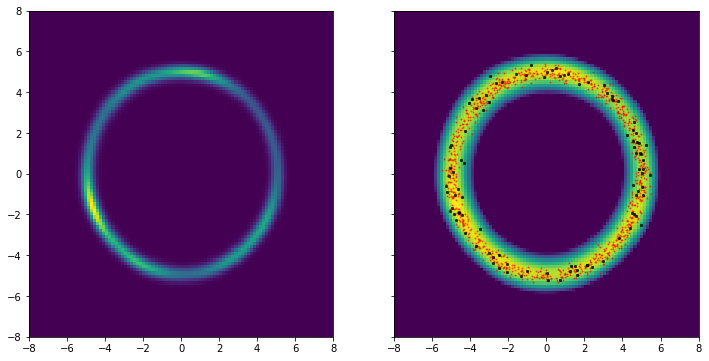

In [35]:
idx_i, idx_j = 0,1

ngrid = 100
eval_grid = np.linspace(-8,8,ngrid)

cond_values = np.zeros(p.D)
epsilon = 1.5

eval_points = get_grid(eval_grid, idx_i, idx_j, cond_values)


fv = dl_model.fun_multiple(eval_points)
gv = dl_model.grad_multiple(eval_points)

#fv = p.logpdf_multiple(eval_points)
#gv = p.grad_multiple(eval_points)
#fv = kde.score_samples(eval_points)


gv = gv.reshape(ngrid, ngrid, p.D)
gint = 5


fig, axes = plt.subplots(1,2, figsize=(12,6), sharex=True, sharey=True)

ax = axes[0]

logpdf = fv.copy() - fv.max()
pdf = np.exp(logpdf - logpdf.max())
pdf /= pdf.sum()
ax.pcolor(eval_grid, eval_grid, pdf.reshape(ngrid, ngrid))
#ax.scatter(p.data[:1000,idx_i], p.data[:1000,idx_j], 1, color="r", alpha=0.9)


ax = axes[1]
points_val = dl_model.sess.run(dl_model.points)
ax.pcolor(eval_grid, eval_grid, logpdf.reshape(ngrid, ngrid), vmin=-10)
ax.scatter(p.data[:1000,idx_i], p.data[:1000,idx_j], 1, color="r", alpha=0.5)
ax.scatter(points_val[:1000,idx_i], points_val[:1000,idx_j], 5, color="k", alpha=0.8, vmin=1, marker="x")
#ax.quiver(eval_grid[::gint], eval_grid[::gint], gv[::gint,::gint,0], gv[::gint,::gint,1], scale=500)

dim = range(p.D)
dim.remove(idx_i)
dim.remove(idx_j)
#idx_in_range = np.all( (p.test_data[:,dim]<cond_values[dim]+epsilon) &  (p.test_data[:,dim]>cond_values[dim]-epsilon), axis=1)
#data_in_range = p.test_data[idx_in_range]

#plt.scatter(data_in_range[:,i], data_in_range[:,j], 15, color="b")

ax.set_xlim(eval_grid.min(),eval_grid.max())

ax.set_ylim(eval_grid.min(),eval_grid.max())

In [36]:
# Visualize kernel

In [10]:
grid_points = get_grid(np.linspace(-5,5,4), idx_i,idx_j,np.zeros(p.D))
grid_data_one=np.linspace(-8,8,100)
grid_data   = get_grid(grid_data_one, idx_i,idx_j,np.zeros(p.D))

plt.figure(figsize=(3,3))
kernel_vals = []
for ki in range(len(dl_model.ops["kernel_grams"])):
    
    kvs = dl_model.sess.run(dl_model.ops["kernel_grams"][ki], feed_dict={dl_model.test_points: grid_points, dl_model.test_data: grid_data})
    kernel_vals.append(kvs)
    for i in range(kvs.shape[0]):
        kv = kvs[i]
        plt.contour(grid_data_one, grid_data_one, kv.reshape(100,100), [0.9], vmin=kv.min(), vmax=kv.max(), colors="C%d"%(i%9), linewidths=[(0.1*(ki+1)**2+3)])
        plt.plot(grid_points[i,idx_i], grid_points[i,idx_j], ".",  color="C%d"%(i%9))
pcolor = plt.pcolor(grid_data_one, grid_data_one, logpdf.reshape(ngrid, ngrid), vmin=-15)
pcolor.set_edgecolor('face')
plt.xlim(grid_data_one.min(),grid_data_one.max())
plt.ylim(grid_data_one.min(),grid_data_one.max())
plt.gca().set_yticks([-5,0,5])
plt.gca().set_aspect("equal", "box")
plt.tight_layout()
#plt.colorbar()
plt.savefig("figs/%s.pdf"%p.name)

NameError: name 'dl_model' is not defined

In [53]:
np.savez("figs/%s_dkef_data", kernel_vals=kernel_vals, logpdf=logpdf, grid_points=grid_points)

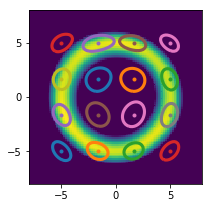

In [11]:

locals().update(np.load("figs/%s_dkef_data.npz"))

idx_i, idx_j=0,1
grid_points = get_grid(np.linspace(-5,5,4), idx_i,idx_j,np.zeros(p.D))
grid_data_one=np.linspace(-8,8,100)
grid_data   = get_grid(grid_data_one, idx_i,idx_j,np.zeros(p.D))

plt.figure(figsize=(3,3))

locals().update()

for ki in range(1):
    kvs = kernel_vals[ki] 
    for i in range(kvs.shape[0]):
        kv = kvs[i]
        plt.contour(grid_data_one, grid_data_one, kv.reshape(100,100), [0.9], vmin=kv.min(), vmax=kv.max(), colors="C%d"%(i%9), linewidths=[(0.1*(ki+1)**2+3)])
        plt.plot(grid_points[i,idx_i], grid_points[i,idx_j], ".",  color="C%d"%(i%9))
pcolor = plt.pcolor(grid_data_one, grid_data_one, logpdf.reshape(ngrid, ngrid), vmin=-15)
pcolor.set_edgecolor('face')
plt.xlim(grid_data_one.min(),grid_data_one.max())
plt.ylim(grid_data_one.min(),grid_data_one.max())
plt.gca().set_yticks([-5,0,5])
plt.gca().set_aspect("equal", "box")
plt.tight_layout()
#plt.colorbar()
plt.savefig("figs/%s.pdf"%p.name)

# Sampling

In [41]:
nsample = 200
Madapt = 100
delta = 0.7
thin = 5
nchain = 1

def lnprobfn(x):
    x = np.atleast_2d(x)
    return dl_model.fun_multiple(x, batch_size=1)[0]


def gradfn(x):
    x = np.atleast_2d(x)
    return dl_model.grad_multiple(x, batch_size=1)[0]

def lnprobgradfun(x):
    x = np.atleast_2d(x)
    return dl_model.fun_multiple(x, batch_size=1)[0], dl_model.grad_multiple(x, batch_size=1)[0]

samples = []
for i in range(nchain):
    #sampler = NUTSSampler(D, lnprobfn, gradfn)
    #s = sampler.run_mcmc(np.zeros(p.D), nsample*thin/nchain, Madapt, delta)
    s, lnprob, epsilon = nuts.nuts6(lnprobgradfun, nsample*thin/nchain, Madapt, np.zeros(p.D), delta)
    samples.append(s[::thin])
samples = np.concatenate(samples, axis=0)

nuts sampling:   0%|▏                                              | 4/1099 [00:00<00:47, 22.92it/s]

('find_reasonable_epsilon=', 0.25)


nuts sampling: 100%|████████████████████████████████████████████| 1099/1099 [01:08<00:00, 16.09it/s]


# Train maf and sample from it

In [90]:
n_hiddens = 100
n_layers = 5
n_comps = 10

act_fun = 'tanh'
mode = 'random'

maf_data_obj = ex.load_data(p.name.lower(), D=p.D, noise_std=noise_std, seed=seed, itanh=False, whiten=True, N=5000)



made_model = ex.train_made([n_hiddens]*2, act_fun, mode)
save_model(made_model, "made", mode, n_hiddens, ac_fun, n_comps, False)
made_pdf = maf_model.eval(eval_points)

mog_made_model = ex.train_mog_made([n_hiddens]*2, act_fun, n_comps, mode)
save_model(mog_made_model, "made", mode, n_hiddens, ac_fun, n_comps, False)
mog_made_pdf = maf_model.eval(eval_points)


nvp_model =ex.train_realnvp([n_hiddens]*2, 'tanh', 'relu', n_layers)
save_model(nvp_model, "made", mode, n_hiddens, ac_fun, n_comps, False)
made_pdf = nvp_model.eval(eval_points)


maf_model = ex.train_maf([n_hiddens]*2, act_fun, n_layers, n_comps, mode)
save_model(maf_model, "maf", mode, n_hiddens, ac_fun, n_comps, False)
made_pdf = nvp_model.eval(eval_points)


mog_maf_model = ex.train_maf_on_made([n_hiddens]*2, act_fun, n_layers, n_comps, mode)
save_model(maf_model, "mog_maf", mode, n_hiddens, ac_fun, n_comps, False)
#maf_data_obj = ex.load_data(dname, noise_std=0.0, seed=seed, itanh=False, whiten=True, N=5000)
#maf_model_clean = ex.train_maf([n_hiddens]*2, act_fun, n_layers, mode)

p.test_data.shape
print maf_model.eval(p.test_data).mean()
maf_samples = maf_model.gen(nsample)

-3.46190731697


NameError: name 'nsample' is not defined

In [75]:
p.test_data.shape
print maf_model.eval(p.test_data).mean()
maf_samples = maf_model.gen(nsample)

-2.43739670226


NameError: name 'nsample' is not defined

# Maf density 

(-8.0, 8.0)

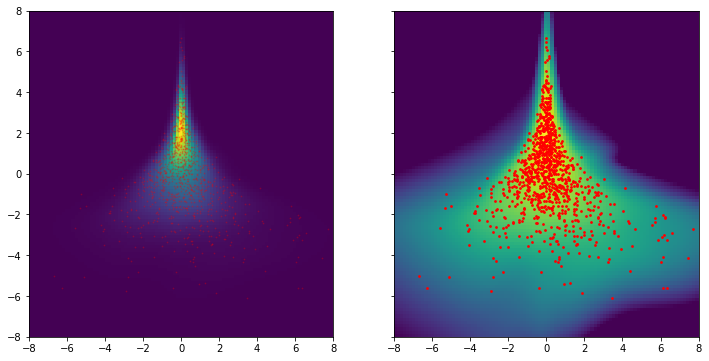

In [91]:
fv = maf_model.eval(eval_points)

fig, axes = plt.subplots(1,2, figsize=(12,6), sharex=True, sharey=True)

ax = axes[0]

logpdf = fv.copy() - fv.max()
pdf = np.exp(logpdf - logpdf.max())
pdf /= pdf.sum()
ax.pcolor(eval_grid, eval_grid, pdf.reshape(ngrid, ngrid))
ax.scatter(p.data[:1000,idx_i], p.data[:1000,idx_j], 1, color="r", alpha=0.2)


ax = axes[1]
ax.pcolor(eval_grid, eval_grid, logpdf.reshape(ngrid, ngrid), vmin=-10)
ax.scatter(p.data[:1000,idx_i], p.data[:1000,idx_j], 3, color="r", alpha=1.0)

dim = range(p.D)
dim.remove(idx_i)
dim.remove(idx_j)
idx_in_range = np.all( (p.test_data[:,dim]<cond_values[dim]+epsilon) &  (p.test_data[:,dim]>cond_values[dim]-epsilon), axis=1)
data_in_range = p.test_data[idx_in_range]
#plt.scatter(data_in_range[:,i], data_in_range[:,j], 15, color="b")

ax.set_xlim(eval_grid.min(),eval_grid.max())
ax.set_ylim(eval_grid.min(),eval_grid.max())

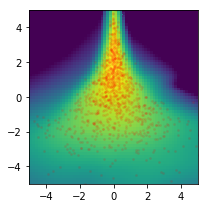

In [92]:
eval_grid = np.linspace(-8,8,ngrid)

grid_points = get_grid(np.linspace(-5,5,4), idx_i,idx_j,np.zeros(p.D))
grid_data_one=np.linspace(-5,5,100)
grid_data   = get_grid(grid_data_one, idx_i,idx_j,np.zeros(p.D))

plt.figure(figsize=(3,3))

pcolor = plt.pcolor(eval_grid, eval_grid, logpdf.reshape(ngrid, ngrid), vmin=-10)
pcolor.set_edgecolor('face')
plt.scatter(p.test_data[:,idx_i], p.test_data[:,idx_j], 3, "r", alpha=0.1)
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.tight_layout()

plt.savefig("figs/%s_mog_maf.pdf"%p.name)


In [52]:
from MMD.mmd import MMD_3_Sample_Test
import h5py as h5

model_name = "maf"
other_noise_std = 0.0

MMD_3_Sample_Test(p.test_data[:nsample], maf_samples, samples, computeMMDs=True)

(0.99999576755084807,
 -4.4530754731168649,
 2.9173867424465181,
 0.0054558133780341356,
 0.02827254509196464)

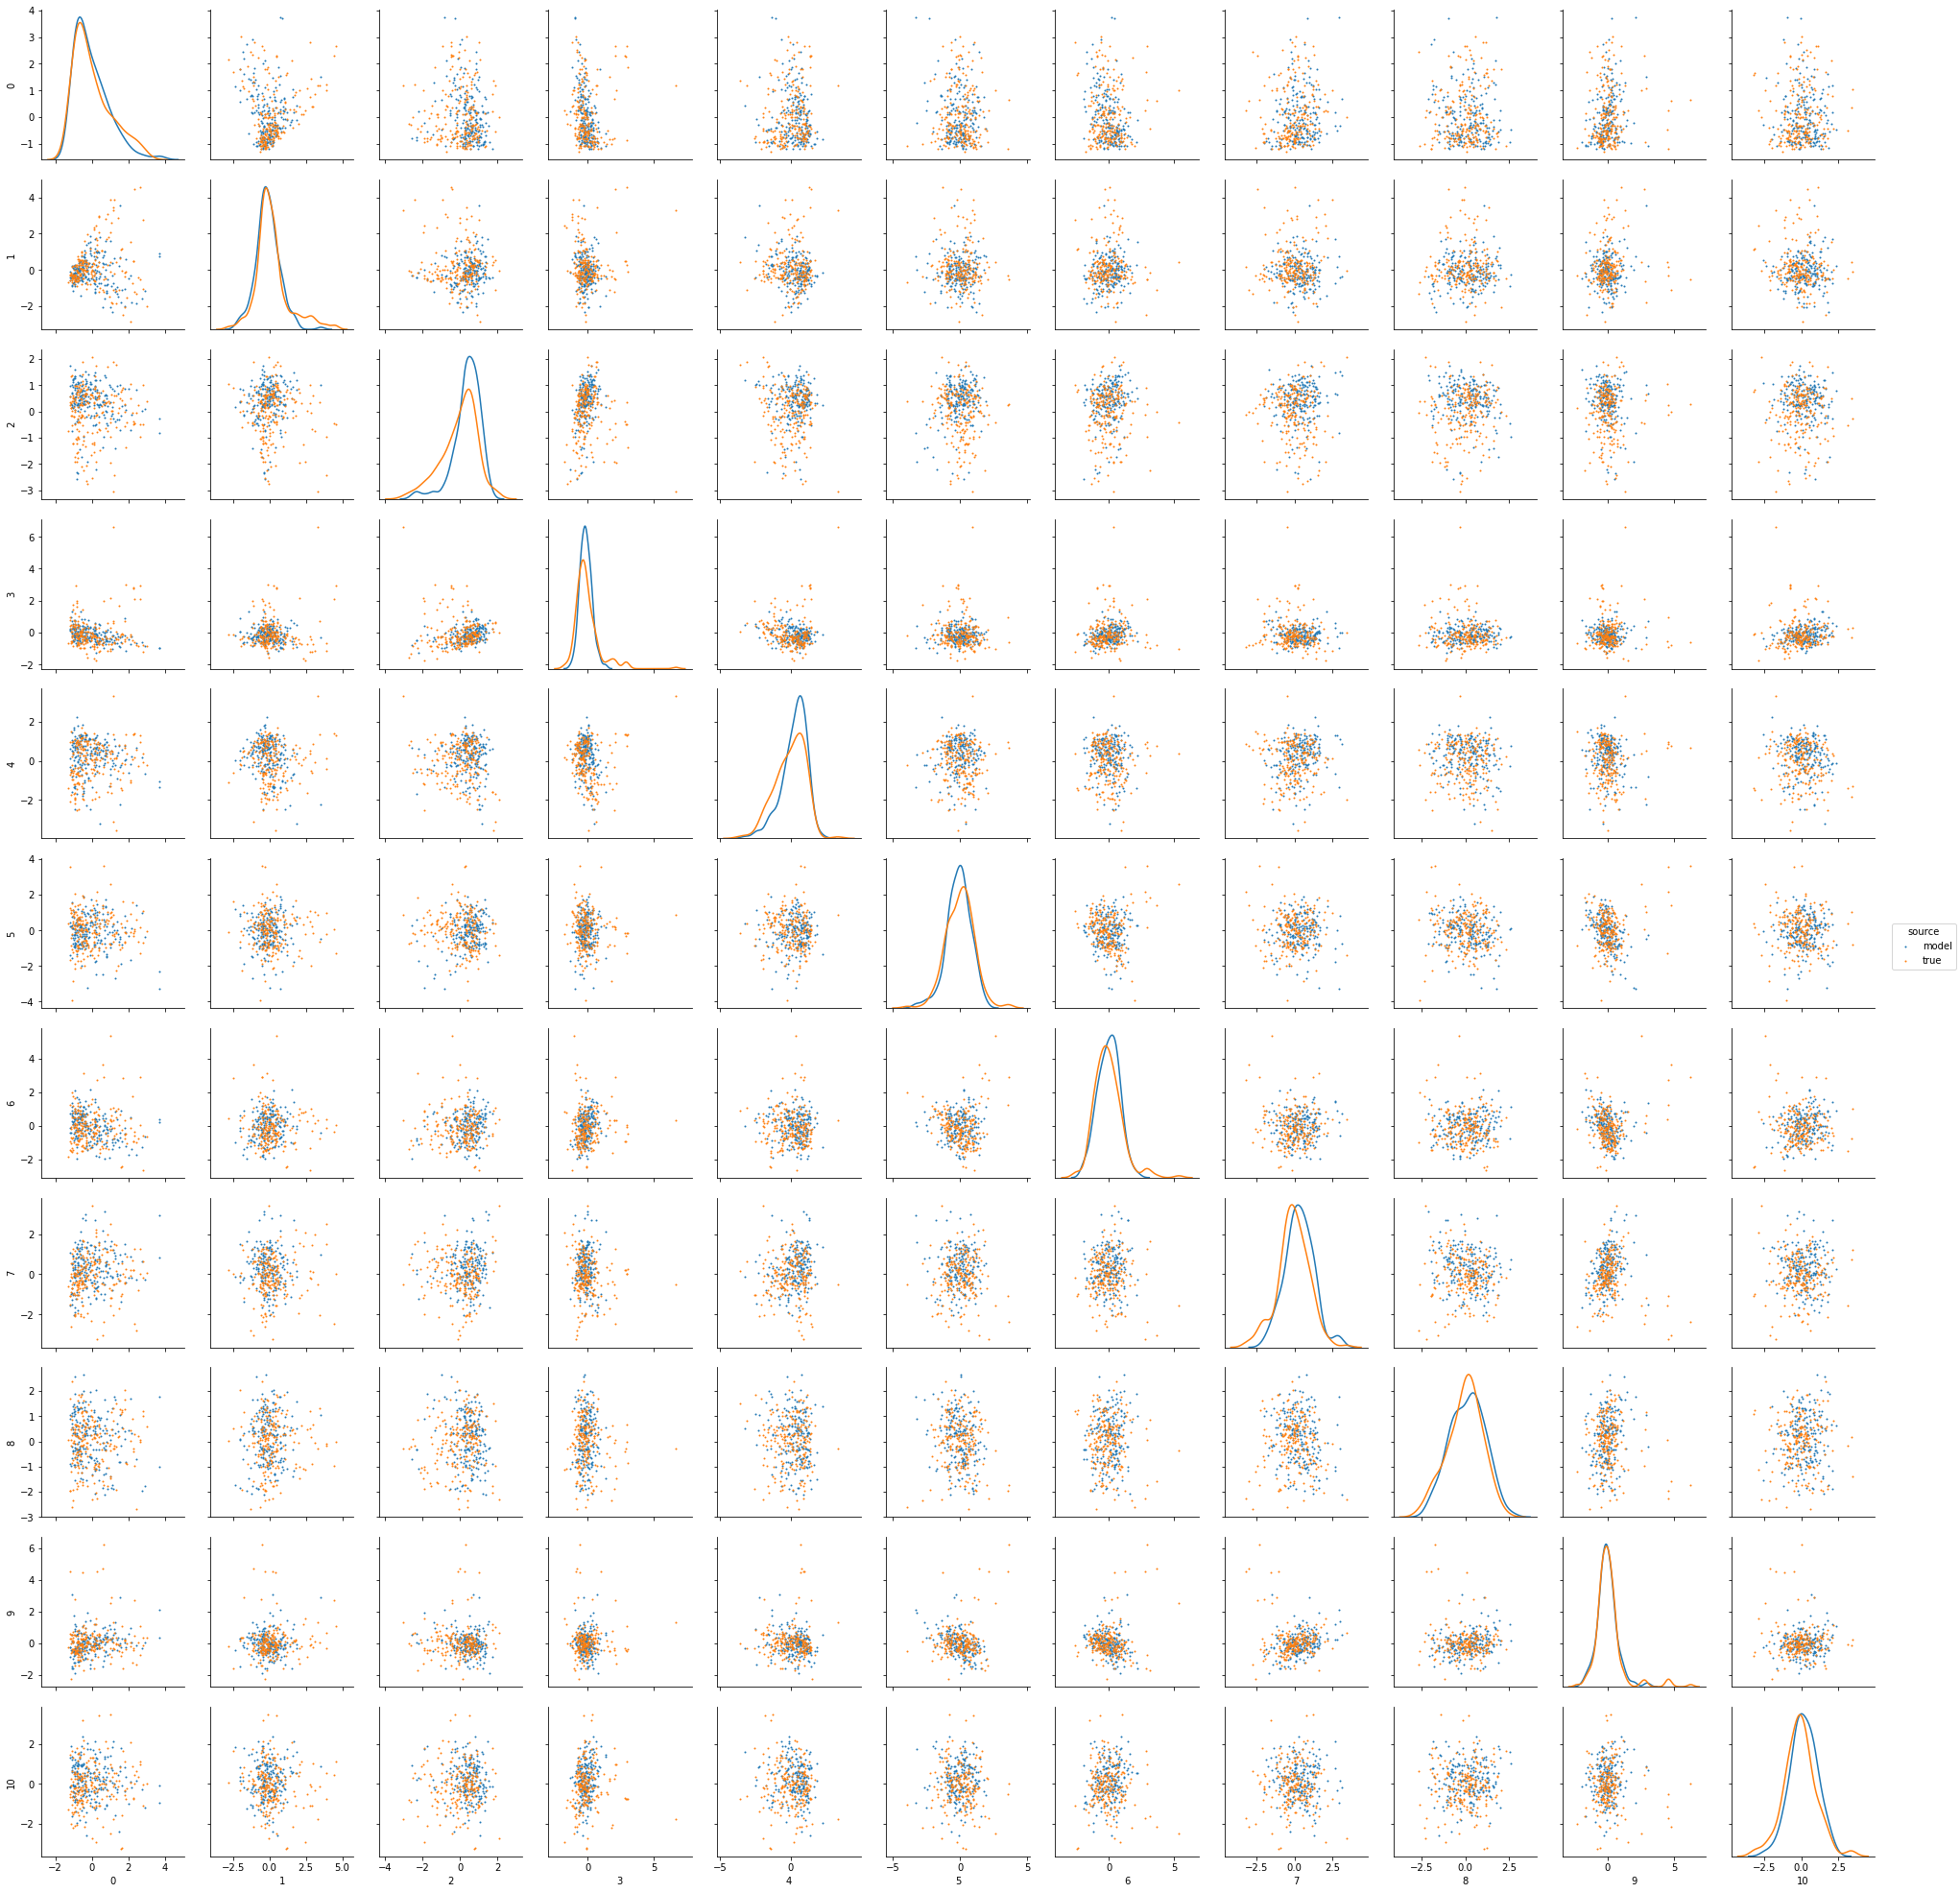

In [53]:
import seaborn as sns
import pandas as pd
perm = np.argsort(p.idx)

model_sample_df = pd.DataFrame(samples[:, :])
model_sample_df["source"] = "model"

true_samples = p.test_data[:nsample]
true_sample_df = pd.DataFrame(true_samples[:, :])
true_sample_df["source"] = "true"

sample_df = pd.concat([model_sample_df, true_sample_df])

fig = sns.pairplot(sample_df, hue="source", size=2.5, diag_kind="kde", kind="scatter",
            plot_kws=dict(s=4, alpha=1.0, linewidth=0),)

#fig.savefig("figs/wine_pairplot.pdf")

# transform maf samples from Gaussian -> generated_data or true_data -> latent 

In [74]:
def plot_samples(x, idx_i, idx_j):
    rn = maf_model.calc_random_numbers(x)
    c = np.arctan2(x[:,0],x[:,1])
    c = c+1.1
    c[c>np.pi]-= 2*np.pi
    c = "r"
    fig, axes = plt.subplots(1,2,figsize=(6,3))

    ax = axes[0]
    ax.scatter(x[:,idx_i], x[:,idx_j], 3, c)
    ax.set_title("data")
    ax = axes[1]
    ax.scatter(rn[:,idx_i], rn[:,idx_j], 3, c)
    ax.set_title("latent")

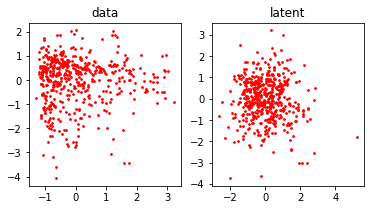

In [75]:
plot_samples(p.test_data, idx_i, idx_j)

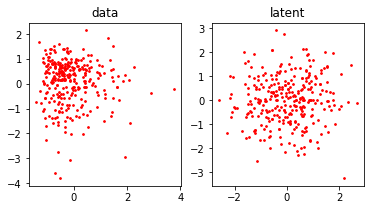

In [77]:
plot_samples(maf_model.gen(300), idx_i, idx_j)

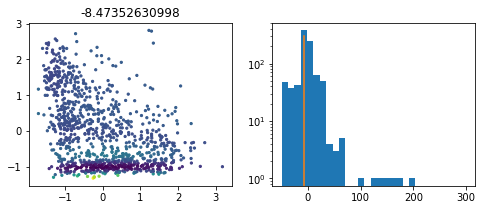

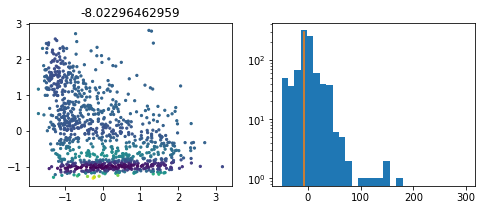

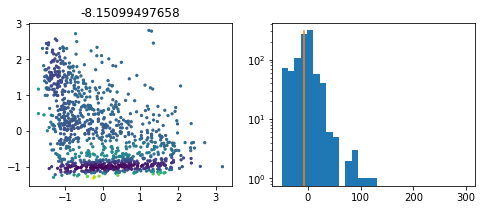

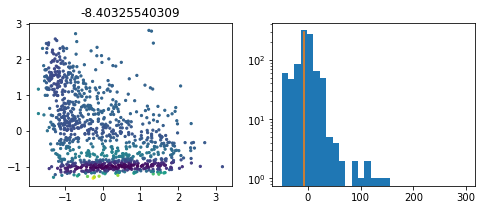

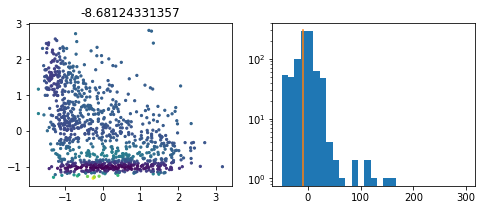

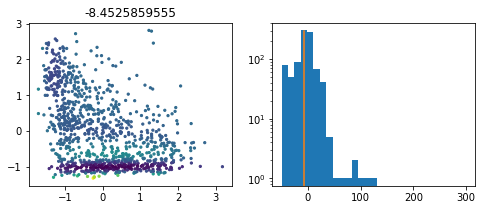

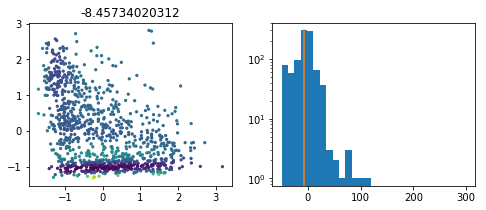

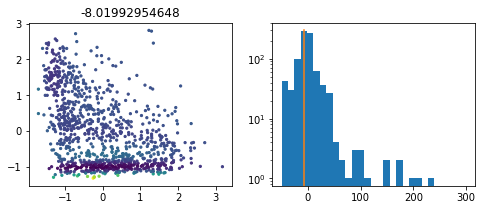

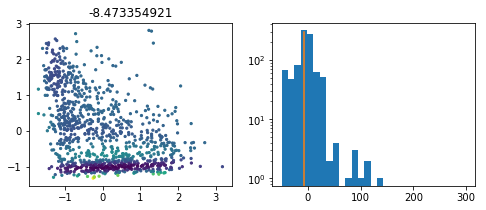

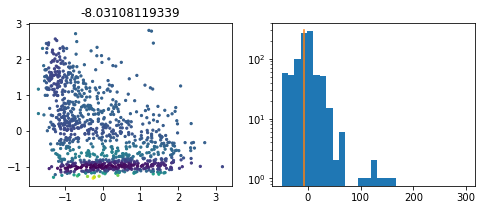

In [22]:
scores = []
logliks = []
for i in range(30):
    
    dl_model.fit_alpha(500)
    sc = dl_model.score_multiple(p.test_data)
    scores.append(sc.mean())
    
    dl_model.logZ = None
    dl_model.estimate_normaliser(n=10**6)
    test_loglik = dl_model.estimate_data_lik(p.test_data, batch_size=p.test_data.shape[0])
    logliks.append(test_loglik/p.ntest)
    
    if i < 10:
        fig, axes = plt.subplots(1,2, figsize=(8,3))

        ax = axes[0]
        ax.scatter(p.test_data[:,0], p.test_data[:,1],5,  sc)
        ax.set_title(sc.mean())

        ax = axes[1]
        ax.hist(sc, log=True, bins=np.linspace(-50,300,30))
        ax.plot([sc.mean(), sc.mean()],[0,300])


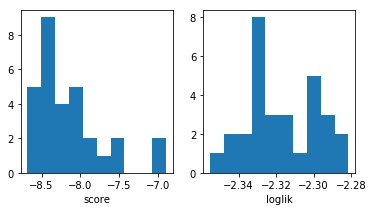

In [29]:
fig, axes = plt.subplots(1,2, figsize=(6,3))
ax = axes[0]
ax.hist(scores)
ax.set_xlabel("score")


ax = axes[1]
ax.hist(logliks)
ax.set_xlabel("loglik")